# Energy calculation for flares in K2 lightcurves
## To Do:
- ~~retrieve colors~~
- ~~retrieve distances for cluster~~
- ~~from colors estimate spectral class~~
- ~~from spectral class use spectrum from Sarah's SpecPhot and Yee 2017~~
- ~~from spectral class use radius from Mamajek 2013~~
- ~~use Kepler filter curve to calculate quiescent flux (maybe use np.polyval to fit a polynomial):~~
- ~~L_∗ = πR^2 ∗int( dλ R_Kepler(λ)* B_SpecPhot(λ))~~
- Finally: ED\*L_=Kepler energy

In [82]:
#if band value == -999.0 no magnitude is given
#read in table for spectral class: read in as list [class,lum_class,u-g,g-r,r-i,i-z,z-J,J-H,H-k,Jmag_abs]
#LATER: Add z-y from mamajek or so...
import numpy as np
def import_pickles98():
    x=np.genfromtxt(
        'share/cross_match/union/spectralclasses_padded.csv',
        skip_header=49,delimiter=',',
        dtype=[('spec_class','U4'),('lum_class','U4'),('u_g',np.float),
               ('g_r',np.float),('r_i',np.float),('i_z',np.float),
               ('z_J',np.float),('J_H',np.float),('H_K',np.float),('Jmag_abs',np.float)])
    spec_class,lum_class,ug,gr,ri,iz,zJ,JH,HK,Jmag_abs = x['spec_class'],x['lum_class'],x['u_g'],x['g_r'],x['r_i'],x['i_z'],x['z_J'],x['J_H'],x['H_K'],x['Jmag_abs']


    spec_class=[x.strip(' ') for x in spec_class]
    lum_class=[x.strip(' ') for x in lum_class]
    lum_class_I=[i for i,x in enumerate(lum_class) if x=='I']
    lum_class_III=[i for i,x in enumerate(lum_class) if x=='III']
    lum_class_V=[i for i,x in enumerate(lum_class) if x=='V']

    spec_class_I=[x for i,x in enumerate(spec_class) if i in lum_class_I]
    spec_class_III=[x for i,x in enumerate(spec_class) if i in lum_class_III]
    spec_class_V=[x for i,x in enumerate(spec_class) if i in lum_class_V]
    #print(spec_class)
    return spec_class,lum_class,ug,gr,ri,iz,zJ,JH,HK,Jmag_abs,lum_class_I,lum_class_III,lum_class_V, spec_class_I, spec_class_III, spec_class_V



In [83]:
def find_spec_class(lookup_spec,color, index,l='V'):
    try:
        spec_class=lookup_spec['class']
        lum_class=lookup_spec[l]

        color_list=lookup_spec[index]
        i_lam=min(color_list, key=lambda x:abs(x-color))
        idx=search(color_list,lum_class,color)
        #print(idx)
        if len(idx)!=0:
            spec_classes=[spec_class[j] for j in idx]

        else:
            spec_classes='color too high or low to be assigned to spectral class in this luminosity class'
        return idx,[spec_classes,l]
    except KeyError:
        idx=[]
        return idx,'no entries for this color index'
    
def search(l,id_, val):
    
    results=[]
    l=list(l)
    id_=list(id_)
    l=list(l)
    l1=[(x,l[x]) for x in id_]

    l2=l1[1:]+[(id_[-1]+1,-l1[-2][1]+2.*l1[-1][1])]
    #print('{}\n{}\n{}'.format(l,l1,id_))
    #print(l1,l2)
    for i,j in zip(l1,l2):
        if i[1]<val<j[1]:
            if (val-i[1] > val-j[1]): 
                results.append(i[0])
            else:
                if (j==l2[-1][1]):
                    results.append(i[0])
                else:
                    results.append(j[0])
    #print(results)
    #print('{}\n{}'.format(results,id_))

    return results
            

In [134]:
import random

def dprint(str,debug):
    if debug==True:
        print(str)
    return

def display(opt,d,debug):
    dprint('New combination: {}'.format(opt),debug)
    dprint('This combination has distance {}'.format(d),debug)
    return
           
def insert_spec_class(c,lookup_spec,c1,c2,index,l='V'):
    if c1!=-999.0 and c2!=-999.0:
        idx,all_spectral_classes=find_spec_class(lookup_spec,c1-c2,index,l)
        c[index]=[c1-c2,all_spectral_classes]
    else:
        idx=[]
    return idx

def insert_lum_class(c,lookup_spec,J,index,l='V'):
    if J!=-999.0:
        J-=dm
        idx, all_spectral_classes=find_spec_class(lookup_spec,J,'Jmag_abs',l)
        c[index]=[J,all_spectral_classes]
    else:
        idx=[]
    return idx

def optimize_spec_class(obj_handle,colors,lookup_spec,c_idx='jhkJ',debug=False):
    
    #Depending on the catalog from the colors are constructed either JHK or grizy is available:
    color_indices={'jhkJ':{'jh':colors[:2],'hk':colors[1:3],'J':colors[3]},'grizyJ':{'gr':colors[:2],'ri':colors[1:3],'iz':colors[2:4],'zy':colors[3:5]}}#,'J':colors[5]
    #Different luminosity classes can occur
    #luminosity_classes={'I':0.01,'III':0.,'V':-0.01}
    #RESTRICT TO DWARFS
    luminosity_classes={'V':-0.01}
    #Now choose a set of colors: jhkJ or grizyJ
    indices=color_indices[c_idx]
    
    #Initialize the procedure:
    lum_opt=dict()
    minspread=10000
    best_lum_class='V'
    best_spec_class='None'
    opt_backup=dict()
    
    #Construct the optimum spec class solution for each luminosity class:
    for lum_class, weight in luminosity_classes.items():
        dprint('-------------',debug)
        dprint(lum_class,debug)
        
        #initialize a list that contain the indices in order to compute the uncertainty on the estimate later
        spr=[]
        #initialize the color indices that are used in the end and their respective values
        color_results={}
        
        #Iterate over all color indices (j,h,k or g,r,i,z,y) to compute possible colors (e.g.: j-h or r-i)
        #This yields a list of possible spectral classes for each color since colors are not 
        #an unambiguous function of spectral class, i.e. several spectral classes can share the same color index
        for key,value in indices.items():
            
            if key=='J':
                #Same goes for luminosity only. Jmag_abs values correspond to spectral classes, too:
                #idx returns the indices into the Pickles'98 table that correspond to spec classes:
                #all of this for the given luminosity class
                idx=insert_lum_class(obj_handle,lookup_spec,value,key,l=lum_class)
            else:
                #unpack the colors for each color index
                c1,c2=value
                #idx returns the indices into the Pickles'98 table that correspond to spec classes:
                #all of this for the given luminosity class
                idx=insert_spec_class(obj_handle,lookup_spec,c1,c2,key,l=lum_class)
 
            #So, for a certain color index name (key) there is a list of indices (idx) that fit into the Pickles'98 table
            color_results[key]=idx
        
        
        dprint(color_results,debug)
        
        #Now given a dict with different colors and possible spec classes for each of them we have to find the best combination
        #This is done by finding the combination which lies closest together within the table and hence has the least uncertainty
        
        #Initialize the a new possible optimum, that may later become the backup solution
        opt=dict()
        #Iterate over all colors and their possible classes to find the closest entries in the other color indices
        for key, value in color_results.items():
            #remove the regarded color index to avoid redundance
            rest_results=dict(color_results)
            del rest_results[key]
            #Iterate over all possible classes (index) for the given central color (key)
            for index in value:
                #add the associated color for the central index
                opt[key]=lookup_spec['class'][index]
                #add central index to the list of indices that should be clostest to each other among all given indices across all colors
                spr.append(index)
                #Init distance list for linear distances
                d=[]
                #Iterate over all other colors and find the indices of possible spectral classes that are closest to the chosen cetral one
                for key2, value2 in rest_results.items():
                    #compute all the linear distances
                    delta=[abs(x-index) for x in value2]
                    if delta!=[]:
                        #find the minimum linear distance
                        dadd=min(delta)
                        d.append(dadd)
                        #find its corresponding index in Pickles'98 table
                        minind=value2[delta.index(dadd)]
                        #add the associated color
                        opt[key2]=lookup_spec['class'][minind]
                        #add to the list of indices that should be closest to each other
                        spr.append(minind)
                
                #distance calculation
                #The row number distance within a padded table is used as proxy to uncertainty
                #distance d is defined as the sum of distances to one of the rows in n-colored space
                d=np.sqrt(sum([x*x for x in d]))/len(color_results)
                
                #select this iteration if it yields a minimum in distance
                try:
                    if d<mindist:
                        #output for debugging
                        display(opt,d,debug)
                        mindist=d
                        opt_backup=dict(opt)
                    else:
                        #output for debugging
                        display(opt,d,debug)
                        dprint('Best solution has been found already, namely: {}'.format(opt_backup),debug)
                        opt.clear()
                #This error occurs if mindist has not yet been assigned
                except UnboundLocalError:
                    #output for debugging
                    display(opt,d,debug)
                    mindist=d
                    opt_backup=dict(opt)
        mindist=0
        del mindist
        #Assign a relative spread within the best solution weighted by the number of colors
        rel_spread=np.std(np.array(spr))
        #Calculate the mean index for the resulting spectral class
        mean=np.mean(np.array(spr))
        dprint('The standard deviation for the optimum solution in this luminosity class is {}'.format(rel_spread),debug)
        #Minimize the spread across all luminosity classes
        try:
            if rel_spread+weight<minspread:
                minspread=rel_spread
                best_lum_class=lum_class
                best_spec_class=lookup_spec['class'][int(np.rint(mean))]
        #This error occurs if rel_spread has not yet been assigned
        except UnboundLocalError:
            minspread=rel_spread
            best_lum_class=lum_class
            best_spec_class=lookup_spec['class'][int(np.rint(mean))]
        #Summarize the results for all luminosity classes in one dict:
        lum_opt[lum_class]=[rel_spread,opt_backup]
        
    dprint('-------------------',debug)
    dprint('Best results for spectral class and luminosity class: L={} and spec={}.'.format(best_lum_class,best_spec_class),debug)
    dprint('',debug)
    
    
    return best_lum_class,best_spec_class,lum_opt



## Here I test the pipeline for a single LC in Ruprecht 147, ID=219652181:

In [120]:
import numpy as np
cluster='Ruprecht_147'
params=open('share/cross_match/union/'+cluster+'_parameter.txt')
param_dict=dict()
basics=params.readline()
#print(basics)
basics=[u for u in basics[1:-2].split(', ')]
for line in params:
    s=np.core.defchararray.split(line, sep=",").tolist()
    col=s[3:]
    col=[float(item) for item in col]
    try:
        param_dict[int(s[0])]=[int(s[1]),s[2],col]
    except ValueError:
        param_dict[int(s[0])]=[s[1],s[2],col]

print(param_dict)

{219599554: [88512891486023288, 'grizyJ', [20.322, 19.307, 18.213, 17.695, 17.438, 12.11]], 219609927: ['19161000-1618431', 'jhkJ', [9.339, 9.059, 8.983, 9.339]], 219519432: [88482891635099879, 'grizyJ', [21.396, 20.138, 19.487, 19.098, 18.852, 10.778]], 219716873: [88442892047034601, 'grizyJ', [-999.0, -999.0, 21.099, 20.335, 19.873, 11.739]], 219396051: [88442892247992582, 'grizyJ', [21.841, 21.197, 21.337, 20.752, -999.0, 11.215]], 219810798: [88482892217271612, 'grizyJ', [-999.0, 21.807, 21.291, 20.946, -999.0, 11.661]], 219444181: [88462891309457389, 'grizyJ', [-999.0, -999.0, 20.887, 20.295, 19.808, 11.365]], 219753819: [88492892038911906, 'grizyJ', [21.716, -999.0, -999.0, -999.0, -999.0, nan]], 219626912: [88442891581988799, 'grizyJ', [-999.0, -999.0, 21.521, -999.0, 19.456, 16.062]], 219712041: [88462892253237168, 'grizyJ', [21.226, 20.327, 20.0, 19.816, 19.637, 15.034]], 219648746: ['19165670-1612265', 'jhkJ', [8.588, 8.271, 8.218, 8.588]], 219630699: [88412891940733291, 'gri

In [117]:
spec_class,lum_class,ug,gr,ri,iz,zJ,JH,HK,Jmag_abs,lum_class_I,lum_class_III,lum_class_V, spec_class_I, spec_class_III, spec_class_V=import_pickles98()
lookup_spec={'Jmag_abs':Jmag_abs,'V':lum_class_V,'III':lum_class_III,'I':lum_class_I,
             'class':spec_class,'ug':ug,'gr':gr,'ri':ri,'iz':iz,'zJ':zJ,'jh':JH,'hk':HK}
#calculate distance modulus for cluster
DM = lambda x: 5.*np.log10(float(x))-5. 
dm=DM(basics[3])
global dm



In [124]:
def optimize_spec_class_ID(objectid,param_dict):
    
    try:
        ID,c_idx,colors,results=param_dict[int(objectid)]
    except ValueError:
        value=param_dict[objectid]
        ID,c_idx, colors=value
        results=value.append(dict())

    best_lum_class,best_spec_class,lum_opt=optimize_spec_class(results,colors,lookup_spec,c_idx=c_idx,debug=True)
    return best_lum_class,best_spec_class,lum_opt

optimize_spec_class_ID('219599554',param_dict)

-------------
V
{'gr': [24], 'ri': [30], 'iz': [28], 'zy': []}
New combination: {'gr': 'K4', 'ri': 'M2.5', 'iz': 'M1'}
This combination has distance 1.8027756377319946
New combination: {'gr': 'K4', 'ri': 'M2.5', 'iz': 'M1'}
This combination has distance 1.5811388300841898
New combination: {'gr': 'K4', 'ri': 'M2.5', 'iz': 'M1'}
This combination has distance 1.118033988749895
The standard deviation for the optimum solution in this luminosity class is 2.494438257849294
-------------
I
{'gr': [96], 'ri': [104], 'iz': [103], 'zy': []}
New combination: {'gr': 'G8', 'ri': 'M2', 'iz': 'K4'}
This combination has distance 2.6575364531836625
New combination: {'gr': 'G8', 'ri': 'M2', 'iz': 'K4'}
This combination has distance 2.0155644370746373
New combination: {'gr': 'G8', 'ri': 'M2', 'iz': 'K4'}
This combination has distance 1.7677669529663689
The standard deviation for the optimum solution in this luminosity class is 3.559026084010437
-------------
III
{'gr': [54], 'ri': [62], 'iz': [60], 'zy': 

('V',
 'M0',
 {'I': [3.5590260840104371, {'gr': 'G8', 'iz': 'K4', 'ri': 'M2'}],
  'III': [3.39934634239519, {'gr': 'K2', 'iz': 'M2', 'ri': 'M3'}],
  'V': [2.4944382578492941, {'gr': 'K4', 'iz': 'M1', 'ri': 'M2.5'}]})

## If the test works, try to process the entire cluster with the function defined below

In [8]:
def optimize_spec_class_all(param_dict, lookup_spec, debug=False):
    ID_lum_spec=[]
    for key,value in param_dict.items():
        #print(key)
        try:
            ID,c_idx,colors,results=value
        except ValueError:
            ID,c_idx, colors=value
            value.append(dict())
            results=value[3]

        best_lum_class,best_spec_class,lum_opt=optimize_spec_class(results,colors,lookup_spec,c_idx=c_idx,debug=debug)
        ID_lum_spec.append((key,best_lum_class,best_spec_class))
    return ID_lum_spec

ID_lum_spec=optimize_spec_class_all(param_dict,lookup_spec,debug=False)
print(ID_lum_spec)

[(219599554, 'V', 'M0'), (219609927, 'I', 'G0'), (219519432, 'V', 'K7'), (219716873, 'V', 'M4'), (219396051, 'V', 'G8'), (219810798, 'V', 'K7'), (219444181, 'V', 'M2'), (219753819, 'V', 'None'), (219626912, 'V', 'None'), (219712041, 'V', 'K3'), (219648746, 'III', 'G5'), (219630699, 'V', 'K4'), (219664556, 'III', 'G5'), (219599730, 'III', 'G5'), (219676654, 'I', 'M2'), (219561713, 'III', 'G0'), (219576178, 'I', 'K3'), (219560884, 'III', 'G5'), (219605951, 'I', 'G0'), (219622634, 'V', 'None'), (219655998, 'III', 'G5'), (219652181, 'III', 'G0')]


/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Plot the results!

In [75]:

from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.layouts import column

spec_class,lum_class,ug,gr,ri,iz,zJ,JH,HK,Jmag_abs,lum_class_I,lum_class_III,lum_class_V, spec_class_I, spec_class_III, spec_class_V=import_pickles98()

def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

lumspecs={'I':f7(spec_class_I),'III':f7(spec_class_III),'V':f7(spec_class_V)}
for key, value in lumspecs.items(): value.append('None')
print(spec_class_V)
#ID, lum, spec=[[x[i] for x in ID_lum_spec] for i in range(3)] 
#print(ID_lum_spec)
figs={}
for key,value in lumspecs.items():
    list_o_tuples=[]
    for item in ID_lum_spec:
        if item[1]==key:
            list_o_tuples.append(item)
    figs[key] = figure(x_range=value, plot_height=250, title=key,toolbar_location=None, tools="")
    top=list()
    for i,spec_class in enumerate(value):
        top.append(0)
        for tuple_ in list_o_tuples:
            if tuple_[2]==spec_class: top[i]+=1
    #print(len(top),len(value))
    figs[key].vbar(x=value, top=top, width=0.9)
    figs[key].xgrid.grid_line_color = None
#print(top,lumspecs['I'])


output_file("bars.html")

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']

p = figure(x_range=fruits, plot_height=250, title="Fruit Counts",
           toolbar_location=None, tools="")

p.vbar(x=fruits, top=[5, 3, 4, 2, 4, 6], width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0

#show(figs['V'])
s1,s2,s3=figs['I'],figs['III'],figs['V']
show(column(s1, s2, s3))

NameError: name 'import_pickles98' is not defined

## Calculate energies

In [13]:
!echo $PATH
#!git clone https://github.com/samuelyeewl/specmatch-emp.git
#%cd specmatch-emp/
#%cd /home/ekaterina/.local/share/jupyter/kernels/python3
#!/home/ekaterina/.virtualenvs/master_thesis/bin/python setup.py install
!type python

#!/home/ekaterina/.virtualenvs/master_thesis/bin/python -m pip install h5py
#!type pip3


/usr/local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin
python is /usr/bin/python


In [147]:
from scipy.constants import pi, h, c, k
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import specmatchemp.library
import specmatchemp.plots as smplot


h*=1e7 # Planck constant in erg*s
c*=1e2 # light speed in cm/s
k*=1e7 # Boltzmann constant in erg/K

#Solution to nan-bug:
#https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return

#End: Solution to nan_bug

def spectrum(T,wavmin=3480., wavmax=9700.):
    
    '''
    
    Returns the spectrum of a star at effective temperature T in wavelength range [wavmin,wavmax]
    Default range corresponds to Kepler response
    
    '''
    #loads library of spectra within wavelength range
    lib = specmatchemp.library.read_hdf(wavlim=[wavmin,wavmax])
    #find the spectrum that fits T best
    Tmin = str(T-50.)
    Tmax = str(T+50.)
    cut = lib.library_params.query(Tmin+'<Teff<'+Tmax)    
    T_offer = zip(list(cut['Teff']), list(cut['lib_index']))
    T_minindex = min(T_offer, key = lambda t: abs(t[0]-T))[1]
    cut = cut.loc[T_minindex]
    #return the spectrum
    spec = lib.library_spectra[cut.lib_index,0,:]
    return lib.wav, spec.T

def kepler_spectrum(T):
    '''
    
    Convolves a blackbody of effective temperature T, 
    the spectrum of a dwarf star with corresponding spectral class,
    and the Kepler response function 
    to return the wavelength dependent flux of that star per area
    
    Input:
    T - effective temperatur in K
    
    Returns:
    Kp_flux in erg/cm*(cm**2)
    Kp_midwav in 
    
    
    '''
    Kp_wav, Kp_resp = np.loadtxt('spectra/Kepler_response.txt',unpack=True)
    Kp_wav*=10. #convert to angström for spectrum function
    #load the spectrum within a wavelength range that fits given T_eff best
    Spec_wav,Spec_flux = spectrum(T,min(list(Kp_wav)),max(list(Kp_wav)))
    #map Kepler response linearly into wavelengths given with the spectrum
    Spec_flux = np.interp(Kp_wav,Spec_wav,Spec_flux)
    Kp_flux = np.empty(len(Kp_wav)-1)
    Kp_midwav  = np.empty(len(Kp_wav)-1)
    #calculate the flux of a star with given T_eff 
    #accounting for Kepler filter 
    #and the corresp. spectrum of that stellar type 
    try:
        for i, response in enumerate(Kp_resp):
            dlambda = (Kp_wav[i+1]-Kp_wav[i])*1e-8 #infin. element of wavelength in cm
            lambda_ = np.mean(Kp_wav[i:i+2])*1e-8 #wavelength in cm
            Kp_midwav[i] = lambda_

            Kp_flux[i] = Spec_flux[i] *response* 2. * h * c**2 / lambda_**5 / (np.exp(h * c / ( lambda_ * k * T ) ) - 1. ) 
            
    except IndexError:
        pass
    
    return Kp_midwav, Kp_flux

def plot_kepler_spectrum(T):

    wav,flux = kepler_spectrum(T)
    plt.figure()
    plt.plot(wav*1e8, flux,color='green')
    plt.show()
    
    return


    

def kepler_luminosity(T):
    
    '''
    Integrates the Kepler flux,
    multiplies by the area A=pi*(R**2),
    to obtain observed quiescent flux for an object
    
    Return:
    
    total Kepler luminosity in erg/s of a dwarf star with effective temperature T
    
    '''
    
    params=pd.read_csv('share/cross_match/union/spec_class_Teff_mamajek.txt')
    
    #calculate Kepler spectrum of a dwarf star with temperature T
    wav,flux=kepler_spectrum(T)
    
    #interpolate where nans occur
    interpolate_nan(wav)
    interpolate_nan(flux)
 
    #select the relevant columns from params
    radii_teff=params[['Teff','R_Rsun']]
    
    #find the entry in radii_teff which lies closest in terms of tempererature to T
    Tmin=min([abs(x-T) for x in radii_teff.Teff])+T
    
    #set index of data frame to be T_eff
    radii_teff.set_index('Teff',inplace=True)

    #select the radius of the given star with T_eff
    try:
        radius_cm=radii_teff.R_Rsun[Tmin]*6.96342e10 #stellar radius in cm
    except KeyError:
        radius_cm=radii_teff.R_Rsun[2.*T-Tmin]*6.96342e10 #stellar radius in cm

    return np.trapz(flux, wav)*pi*(radius_cm**2)

kepler_luminosity(6340.)

Reading library from /home/ekaterina/.specmatchemp/library.h5


2.2244596022786706e+32

In [112]:
def spec_class_to_Teff(s):
    params=pd.read_csv('share/cross_match/union/spec_class_Teff_mamajek.txt')
    #set index of data frame to be T_eff
    params.set_index('Teff',inplace=True)
    #find and return the T_eff that correspods to the given spectral class:
    return params[params.dwarf==s].index.values[0]

spec_class_to_Teff('K4')

4620

# Appendix
### This is a deprecated analysis version. Left here for later reference.

In [113]:
for key,value in param_dict.items():
    
    if len(value)==4:
        c=value[3]
    else:
        value.append(dict())
        c=value[3]
    if value[1]=='jhkJ':
        j,h,k,J=value[2]
        insert_spec_class(c,lookup_spec,j,h,'jh')
        insert_spec_class(c,lookup_spec,h,k,'hk')
        insert_lum_class(c,lookup_spec,J,'J')
        
    elif value[1]=='grizyJ':
        g,r,i,z,y,J=value[2]
        insert_spec_class(c,lookup_spec,g,r,'gr')
        insert_spec_class(c,lookup_spec,r,i,'ri')
        insert_spec_class(c,lookup_spec,i,z,'iz')
        insert_spec_class(c,lookup_spec,z,y,'zy')
        insert_lum_class(c,lookup_spec,J,'J')

    #print(key,c)
#check with spectral class table. find value in ordered list
#check distance with luminosity class using absolute Jmag_abs and J from param_dict
#add color_index, spec_class to obj#bokeh barplot spectral classes

# Plotting the flare frequency as a function of ED for by-hand analysis

In [180]:
import numpy as np
from scipy.integrate import trapz
import matplotlib.pyplot as plt
cluster='Ruprecht_147'

In [185]:

objectid='219519432'
t_start,t_stop,id_start,id_stop,comment=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'_my_flares.txt',delimiter=',',unpack=True,dtype=[('t_start', np.float), ('t_stop', np.float), ('id_start', np.int), ('id_stop', np.int), ('comment', 'S32')])
time,flux_gap,error,flux_model=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'.txt',delimiter=',',unpack=True)
istart, istop=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'_flares.txt',delimiter=',',unpack=True,dtype=np.dtype(np.int16))

best_lum_class,best_spec_class,lum_opt = optimize_spec_class_ID(objectid,param_dict)
T=float(spec_class_to_Teff(best_spec_class))
print(T)
L_quiet=kepler_luminosity(T)
print('The quiescent Kepler luminosity for this spectral class is {}.'.format(L_quiet))

-------------
V
{'gr': [25], 'ri': [27], 'iz': [27], 'zy': []}
New combination: {'gr': 'K5', 'ri': 'M0', 'iz': 'M0'}
This combination has distance 0.7071067811865476
New combination: {'gr': 'K5', 'ri': 'M0', 'iz': 'M0'}
This combination has distance 0.5
New combination: {'gr': 'K5', 'ri': 'M0', 'iz': 'M0'}
This combination has distance 0.5
Best solution has been found already, namely: {'gr': 'K5', 'iz': 'M0', 'ri': 'M0'}
The standard deviation for the optimum solution in this luminosity class is 0.9428090415820634
-------------------
Best results for spectral class and luminosity class: L=V and spec=K7.

4070.0
Reading library from /home/ekaterina/.specmatchemp/library.h5
The quiescent Kepler luminosity for this spectral class is 5.446067550045679e+30.


In [186]:
def ED(start,stop,time,flux_model,flux_gap):
    time=time[start:stop+1]
    model=flux_model[start:stop+1]
    flux=flux_gap[start:stop+1]
    residual=np.subtract(flux,model)
    flare=trapz(residual,time)
    quiet=trapz(model,time)
    ed=flare/quiet
    return ed


In [187]:

myED=[]

for start, stop in zip(id_start,id_stop):
    ed=ED(start,stop,time,flux_model,flux_gap)
    myED.append(np.log10(ed*24.*60.*60.*L_quiet))
    histmy, bin_edges1=np.histogram(myED, bins=5)

    
AppaED=[]

for start, stop in zip(istart,istop):
    ed=ED(start,stop,time,flux_model,flux_gap)
    AppaED.append(np.log10(ed*24.*60.*60.*L_quiet))
    histAppa, bin_edges2=np.histogram(AppaED,bins=bin_edges1)

print(histAppa)
print(histmy)
bin_edges_help=bin_edges1[1:]
binmids=[(x+bin_edges1[i])/2. for i,x in enumerate(bin_edges_help)]
print(type(histAppa))

[ 3 13  1  2  0]
[19 21 14  7  4]
<class 'numpy.ndarray'>


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


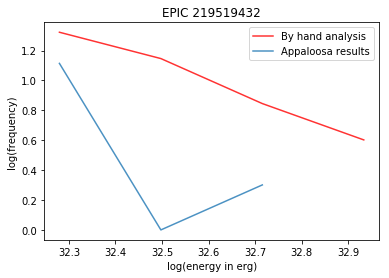

In [188]:

plt.figure()
plt.title('EPIC '+objectid)
plt.plot(binmids[1:],np.log10(histmy[1:]),alpha=0.8,color='red',label='By hand analysis')
plt.plot(binmids[1:],np.log10(histAppa[1:]),alpha=0.8,label='Appaloosa results')
#plt.hist(myED,len(myED)//5,alpha=0.8,color='red',label='By hand analysis')
#plt.hist(AppaED,len(AppaED)//1,alpha=0.8,label='Appaloosa results')
plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')
plt.show()
#plt.savefig('results/'+objectid+'_byhand_vs_Appaloosa.png')